# Slicer Dashboard Stats

This notebook allows to collect statistics associated with the configuration, building and testing of Slicer extensions.

The Slicer extensions are built on a daily basis on Linux, MacOSX and Windows. The following two plots are intented to help understanding (1) how much time it takes to build, configure and test each extension and (2) which extension failed to build.

Currently, the plots are explicitly generated for a given date. Ultimately, this notebook will be improved and should allow us to understand how build parameters affect the performance of the build infrastucture.


## List of plots

 1. [Bar chart of 'configure+build+test' times by site by extension](#plot_1)
 2. [Gantt chart of |configure, build, test| times by extension (ordered by start times)](#plot_2)


## Sections

* [Todos](#Todos)
* [Prerequisites](#Prerequisites)
* [Download data from CDash](#Download-data-from-CDash)
* [Transform data](#Transform-data)
* [For each site, collect extensions that failed to configure or build](#For-each-site,-collect-extensions-that-failed-to-configure-or-build)
* [Display cumulative times for all extensions](#Display-cumulative-times-for-all-extensions)
* [Visualize extension times and errors](#Visualize-extension-times-and-errors)
 * [Bar chart of 'configure+build+test' times by site by extension](#plot_1)
* [Gantt chart of extension times](#Gantt-chart-of-extension-times)
 * [Gantt chart of |configure, build, test| times by extension (ordered by start times)](#plot_2)

## Todos

* Retrieve list of expected extensions checking out the Extensions index
* Initialize `sites_df` using list of expected extensions
* Retrieve list of extensions packages effectively uploaded in the extensions manager


### Prerequisites

In [1]:
! pip install arrow

### Download data from CDash

Using `cdashapi.Downloader`, we can selectively download data.


In [2]:
url = "slicer.cdash.org"
project = "Slicer4"

sites = ['factory-south-ubuntu', 'factory-south-w', 'factory']
date = "2016-04-24"
group = "Extensions-Nightly"

from cdashapi import Downloader

sites_data = {}

for site in sites:
    print("Downloading '%s' site data..." % site)
    sites_data[site] = (
        Downloader(url, project, date=date).debug(False).
        site(site).
        groupname(group)()
    )
    
# pp(sites_data[site])

### Transform data


In [3]:
import arrow
import pandas as pd

from cdashapi import Transformer

# Create dataframe with 
#  
#  * a hierarchical index of the form: <sites> ( <names> )
#
#  * data columns

sites_data_columns = ['start_times']

timedelta_columns = ['configure_times', 'build_times', 'test_times']
sites_data_columns.extend(timedelta_columns)

error_columns = ['configure_errors', 'build_errors']
sites_data_columns.extend(error_columns)

data_columns = list(sites_data_columns)

sites_df = None

for site, submission_data in sites_data.items():
    
    site_data = (Transformer(submission_data).
                 labels().
                 start_times(update=lambda value:pd.Timestamp(arrow.get(value).datetime)).
                 configure_times().build_times().test_times().
                 configure_errors().build_errors().transformed_data())
    
    # Keys for each level of indexing
    sites_index = [site]
    names_index = site_data['labels']
    
    # Explicit building of the index and association of names with each levels
    index = pd.MultiIndex.from_product([sites_index, names_index],
                                       names=['sites', 'names'])
    
    # Convert column based representation into list of tuples
    data_tuples = list(zip(*(site_data[key] for key in sites_data_columns)))
    
    # Create site dataframe with (1) list of data tuples and (2) hierarchical index
    site_df = (pd.DataFrame(data_tuples, index=index, columns=sites_data_columns))
    
    # Compute errors <= configure_errors + build_errors
    site_df['errors'] = site_df[error_columns].sum(axis=1)
    if 'errors' not in data_columns: data_columns.append('errors')
    
    print(" site_df: [%d rows x %d columns][%s]" % (*site_df.shape, site))
    
    if sites_df is None:
        sites_df = site_df
    else:
        sites_df = sites_df.merge(site_df, left_index=True, right_index=True, how='outer', on=data_columns)

print("sites_df: [%d rows x %d columns]" % (sites_df.shape))

 site_df: [86 rows x 7 columns][factory-south-w]
 site_df: [94 rows x 7 columns][factory]
 site_df: [82 rows x 7 columns][factory-south-ubuntu]
sites_df: [262 rows x 7 columns]


In [4]:
import pandas as pd

def merge(_dfs, **kwargs):
    dfs = list(_dfs) # Copy
    #print(dfs)
    merged = None
    if len(dfs) > 0:
        merged = dfs.pop(0)
    while len(dfs) > 0:
        merged = pd.merge(merged, dfs.pop(0), **kwargs)
    return merged

### For each site, collect extensions that failed to configure or build

In [5]:
sites_failed_extension_names = {}

print("Number of extensions that failed to build on %s:" % date)

for site in sites:
    # get extensions with errors
    site_df = sites_df.xs((site), level=('sites'))
    failed = (site_df['errors'].
              where(site_df['errors'] > 0).
              dropna().
              index.get_level_values('names').values)
    
    print("  site[%s]: %d" % (site,len(failed)))
    
    sites_failed_extension_names[site] = failed


Number of extensions that failed to build on 2016-04-24:
  site[factory-south-ubuntu]: 16
  site[factory-south-w]: 22
  site[factory]: 20


### Display cumulative times for all extensions

In [6]:
import numpy as np

# Sum values associated for the current site and 'times' index keys
print("For all extensions on %s :" % date)
for site in sites:
    print("  site: %s" % site)
    cumulative_times = sites_df.xs((site), level=('sites'))[timedelta_columns].sum() / np.timedelta64(1, 'h')
    for key in timedelta_columns:
        print("    %s: %.2f hrs" % (key, cumulative_times[key]))
    total = (sites_df.xs((site), level=('sites'))[timedelta_columns]).sum(axis=1).sum() / np.timedelta64(1, 'h')
    print("    (configure + build + test) time: %.2f hrs" % (total))
    print("")

For all extensions on 2016-04-24 :
  site: factory-south-ubuntu
    configure_times: 0.12 hrs
    build_times: 6.14 hrs
    test_times: 0.25 hrs
    (configure + build + test) time: 6.51 hrs

  site: factory-south-w
    configure_times: 0.52 hrs
    build_times: 5.70 hrs
    test_times: 0.64 hrs
    (configure + build + test) time: 6.86 hrs

  site: factory
    configure_times: 0.17 hrs
    build_times: 4.10 hrs
    test_times: 0.77 hrs
    (configure + build + test) time: 5.04 hrs



In [7]:
from IPython.display import display, HTML 
def section(_id):
    #print("Adding <a id='%s'></a>" % _id)
    display(HTML("<a id='%s'></a>" % _id))
    
import itertools

def ticklabels_mark_failed_extensions(ticklabels, site=None, fontsize=14, position=(0.05, 0.95)):
    # mark extension that failed

    extra_txt = ""
    if site is None:
        failed = [name for name in itertools.chain.from_iterable(sites_failed_extension_names.values())]
        extra_txt = " on at least one site"
    else:
        failed = sites_failed_extension_names[site]
    for ticklabel in ticklabels:
        if ticklabel.get_text() in failed:
            ticklabel.set_color('r')
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    txt = ax.text(*position,
                  "Extension name in red:\nConfigure or build errors" + extra_txt,
                  transform=ax.transAxes, fontsize=fontsize,
                  verticalalignment='top', bbox=props)
    txt.color = 'r'

### Visualize extension times and errors

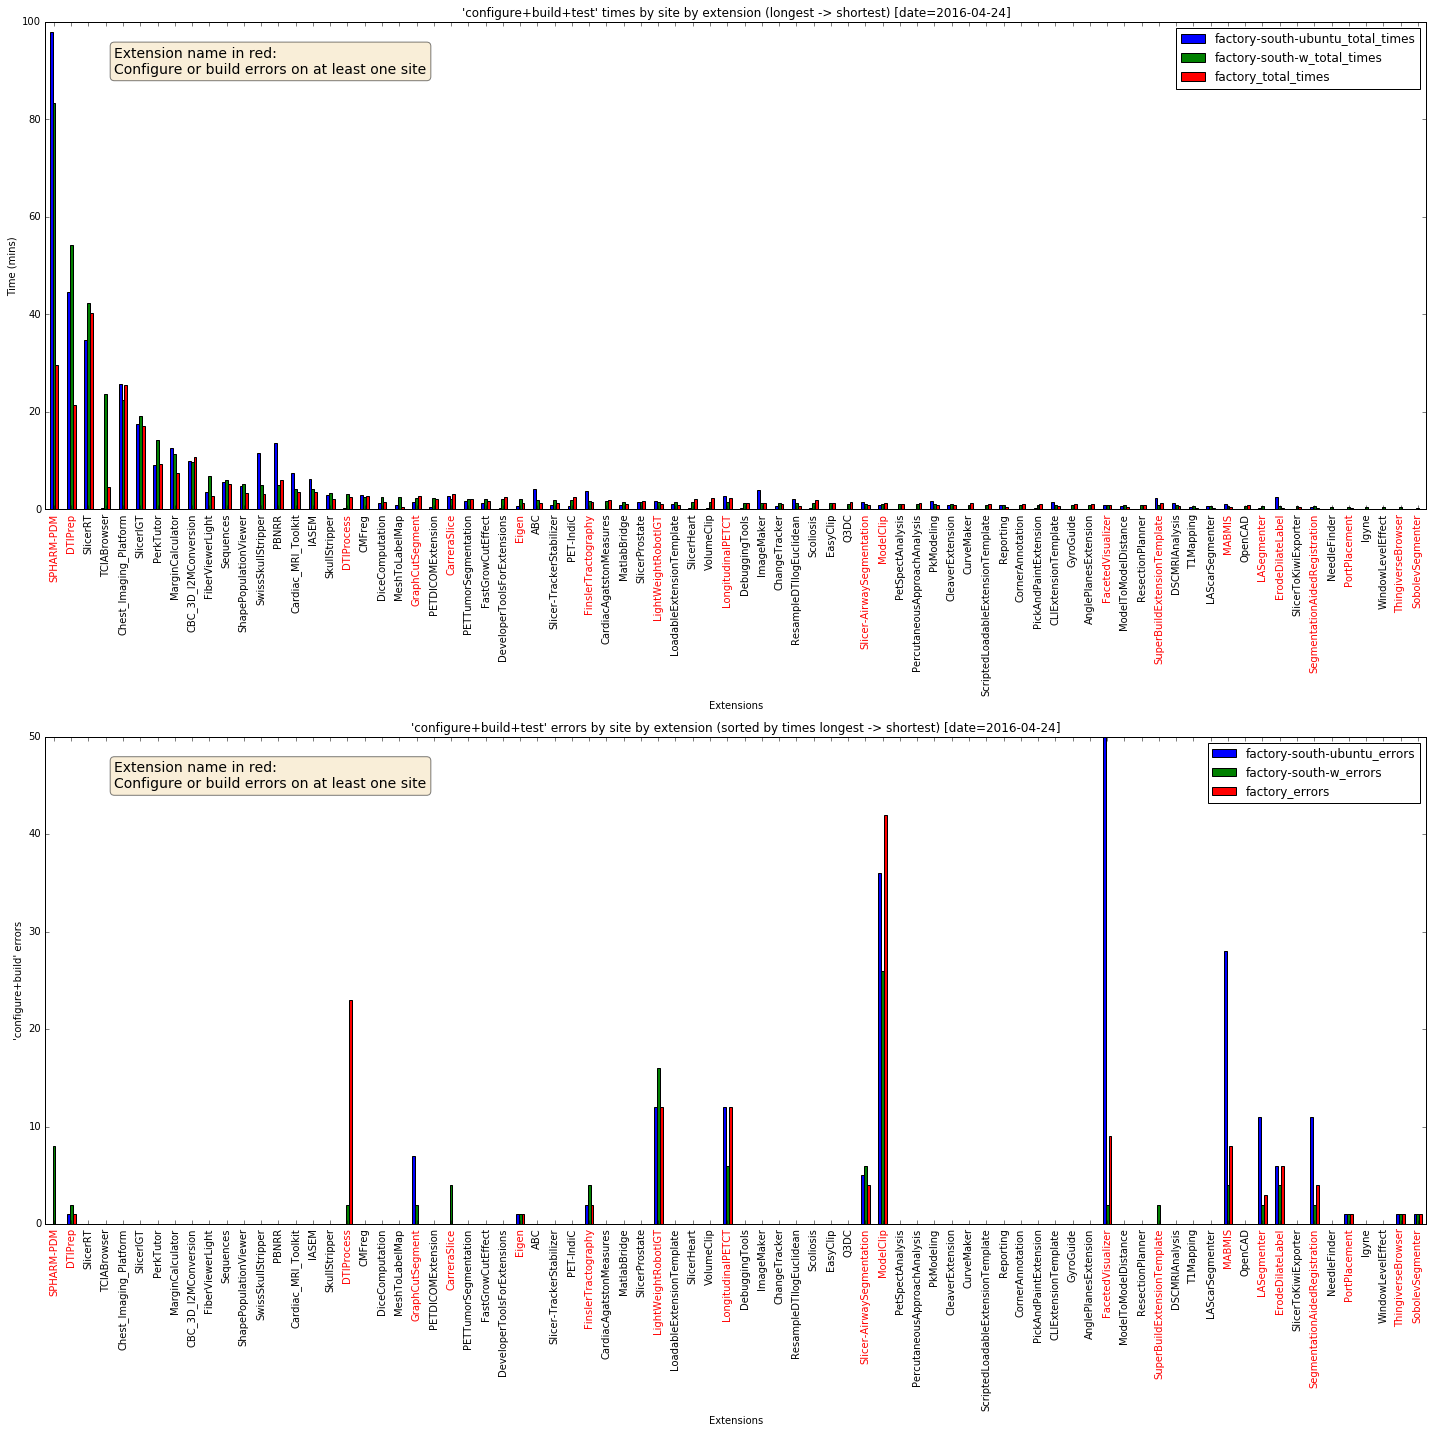

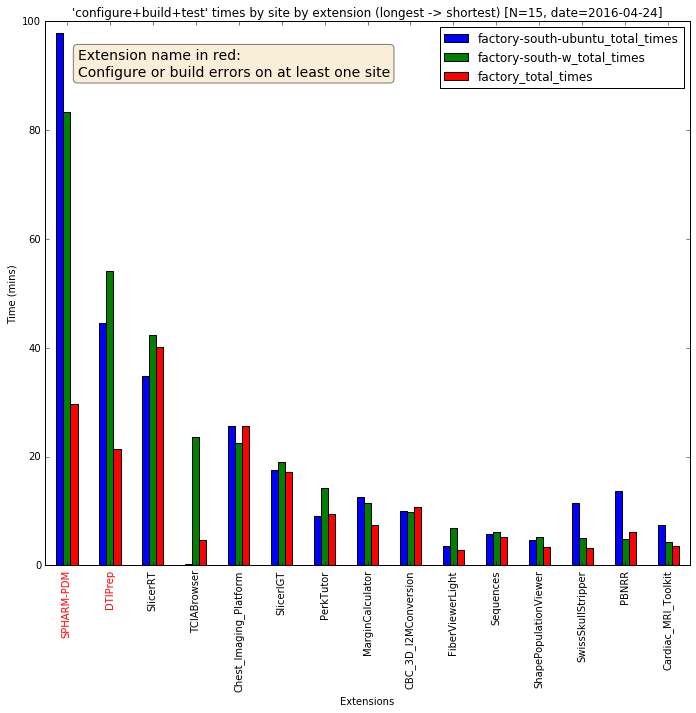

In [8]:
%matplotlib inline

section('plot_1')

import matplotlib.pyplot as plt

figsize = (20, 20)
sharex = False

# fig, axes = plt.subplots(2, sharex=sharex)
# axes_index = iter(range(len(axes)))

# subplot
title = "'configure+build+test' times by site by extension (alphabetical) [date=%s]" % date

time_plot_df = merge(
    [(sites_df.xs((site), level=('sites'))                       # for each site
      [timedelta_columns].sum(axis=1) / np.timedelta64(1, 'm')). # compute total_times <= configure+build+test
     to_frame('%s_total_times' % site)                           # convert from time series and rename
     for site in sites],
    left_index=True, right_index=True                            # finally, merge
).sortlevel(level='names')                                       # and sort

# ax = time_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
# ax.set_xlabel("Extensions")
# ax.set_ylabel("Time (mins)")
# ticklabels_mark_failed_extensions(ax.get_xticklabels())

# subplot
title = "'configure+build' errors by site by extension (alphabetical) [date=%s]" % date

error_plot_df = merge(
    [(sites_df.xs((site), level=('sites'))                       # for each site
      ['errors']). # compute total_times <= configure+build+test
     to_frame('%s_errors' % site)                                # convert from time series and rename
     for site in sites],
    left_index=True, right_index=True                            # finally, merge
).sortlevel(level='names')                                       # and sort

# ax = error_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
# ax.set_xlabel("Extensions")
# ax.set_ylabel("'configure+build' errors")
# ticklabels_mark_failed_extensions(ax.get_xticklabels())

#plt.tight_layout()

#-------------------------------------------------------------------------------

fig, axes = plt.subplots(2, sharex=sharex)
axes_index = iter(range(len(axes)))

# subplot
title = "'configure+build+test' times by site by extension (longest -> shortest) [date=%s]" % date

time_plot_df = time_plot_df.sort_values(by='factory-south-w_total_times', ascending=False)

ax = time_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("Time (mins)")
ticklabels_mark_failed_extensions(ax.get_xticklabels())

# subplot
title = "'configure+build+test' errors by site by extension (sorted by times longest -> shortest) [date=%s]" % date

error_plot_df = error_plot_df.reindex_axis(time_plot_df.index.get_level_values('names'))

ax = error_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("'configure+build' errors")
ticklabels_mark_failed_extensions(ax.get_xticklabels())

plt.tight_layout()

#-------------------------------------------------------------------------------

fig = plt.figure()
figsize = (10, 10)

number=15
title = "'configure+build+test' times by site by extension (longest -> shortest) [N=%d, date=%s]" % (number, date)

time_plot_df = time_plot_df.head(number)

ax = time_plot_df.plot.bar(figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("Time (mins)")
ticklabels_mark_failed_extensions(ax.get_xticklabels())

plt.tight_layout();

### Gantt chart of extension times

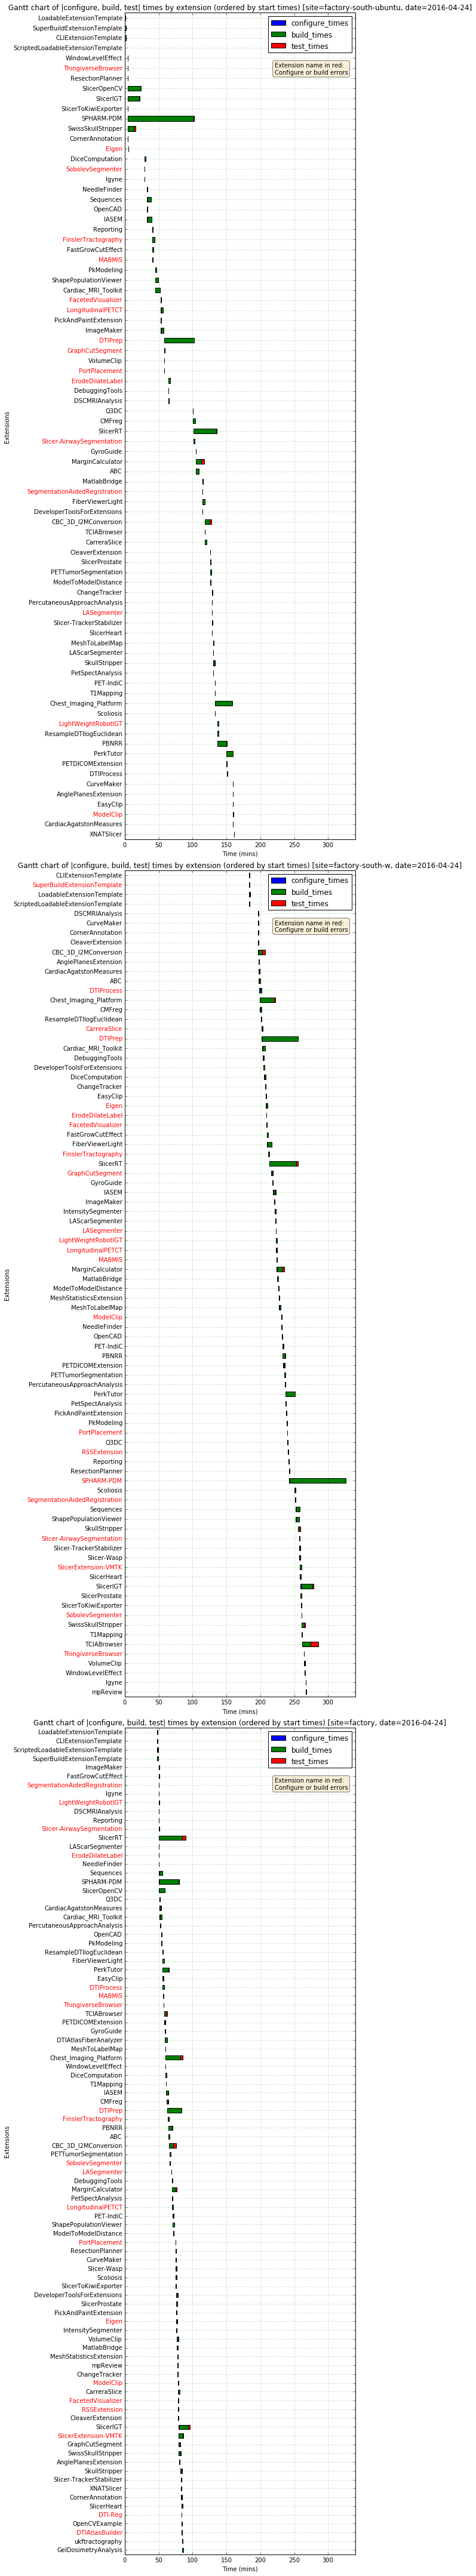

In [9]:

section('plot_2')

figsize = (10, 60)

fig, axes = plt.subplots(len(sites), sharex=False)
axes_index = iter(range(len(axes)))

reference_time = None
overall_xmin = 0
overall_xmax = 0

for site in sites:

    title = "Gantt chart of |configure, build, test| times by extension (ordered by start times) [site=%s, date=%s]" % (site, date)

    # select rows matching 'site'
    sites_sorted_df = sites_df.xs((site), level=('sites')).sort_values(by='start_times', ascending=False)

    # select all 'times' columns and convert to floats
    time_plot_df = (((sites_sorted_df[timedelta_columns]).
                     apply(lambda td: td / np.timedelta64(1, 'm'))) # convert timedeltas to floats
                   )

    # select 'start_times'
    start_times = sites_sorted_df['start_times']
    
    # set reference time if needed
    if reference_time is None:
        reference_time = start_times.min()
    
    # compute offset
    offset = reference_time - start_times.min()
    
    # compute relative location of each configure+build+test
    barh_x = ((start_times - start_times.min()) - offset) / np.timedelta64(1, 'm')

    ax = time_plot_df.plot.barh(
        ax=axes[next(axes_index)],
        figsize=figsize, 
        title=title,
        use_index=True,
        stacked=True,
        left=barh_x)
    ax.set_xlabel("Time (mins)")
    ax.set_ylabel("Extensions")
    ax.grid(color = 'g', linestyle = ':')
    
    # Keep track of the smallest/largest limit accross all sites
    if ax.get_xlim()[0] < overall_xmin:
        overall_xmin = ax.get_xlim()[0]
    if ax.get_xlim()[1] > overall_xmax:
        overall_xmax = ax.get_xlim()[1]
    
    # mark extension that failed
    ticklabels_mark_failed_extensions(ax.get_yticklabels(), site, fontsize=10, position=(0.65, 0.94))

# Update x limites
for site in sites:
    axes[sites.index(site)].set_xlim([overall_xmin, overall_xmax])

plt.tight_layout();